  0%|          | 0/4612 [00:00<?, ?it/s]

100%|██████████| 93/93 [00:34<00:00,  2.71it/s]


Total samples processed: 4662


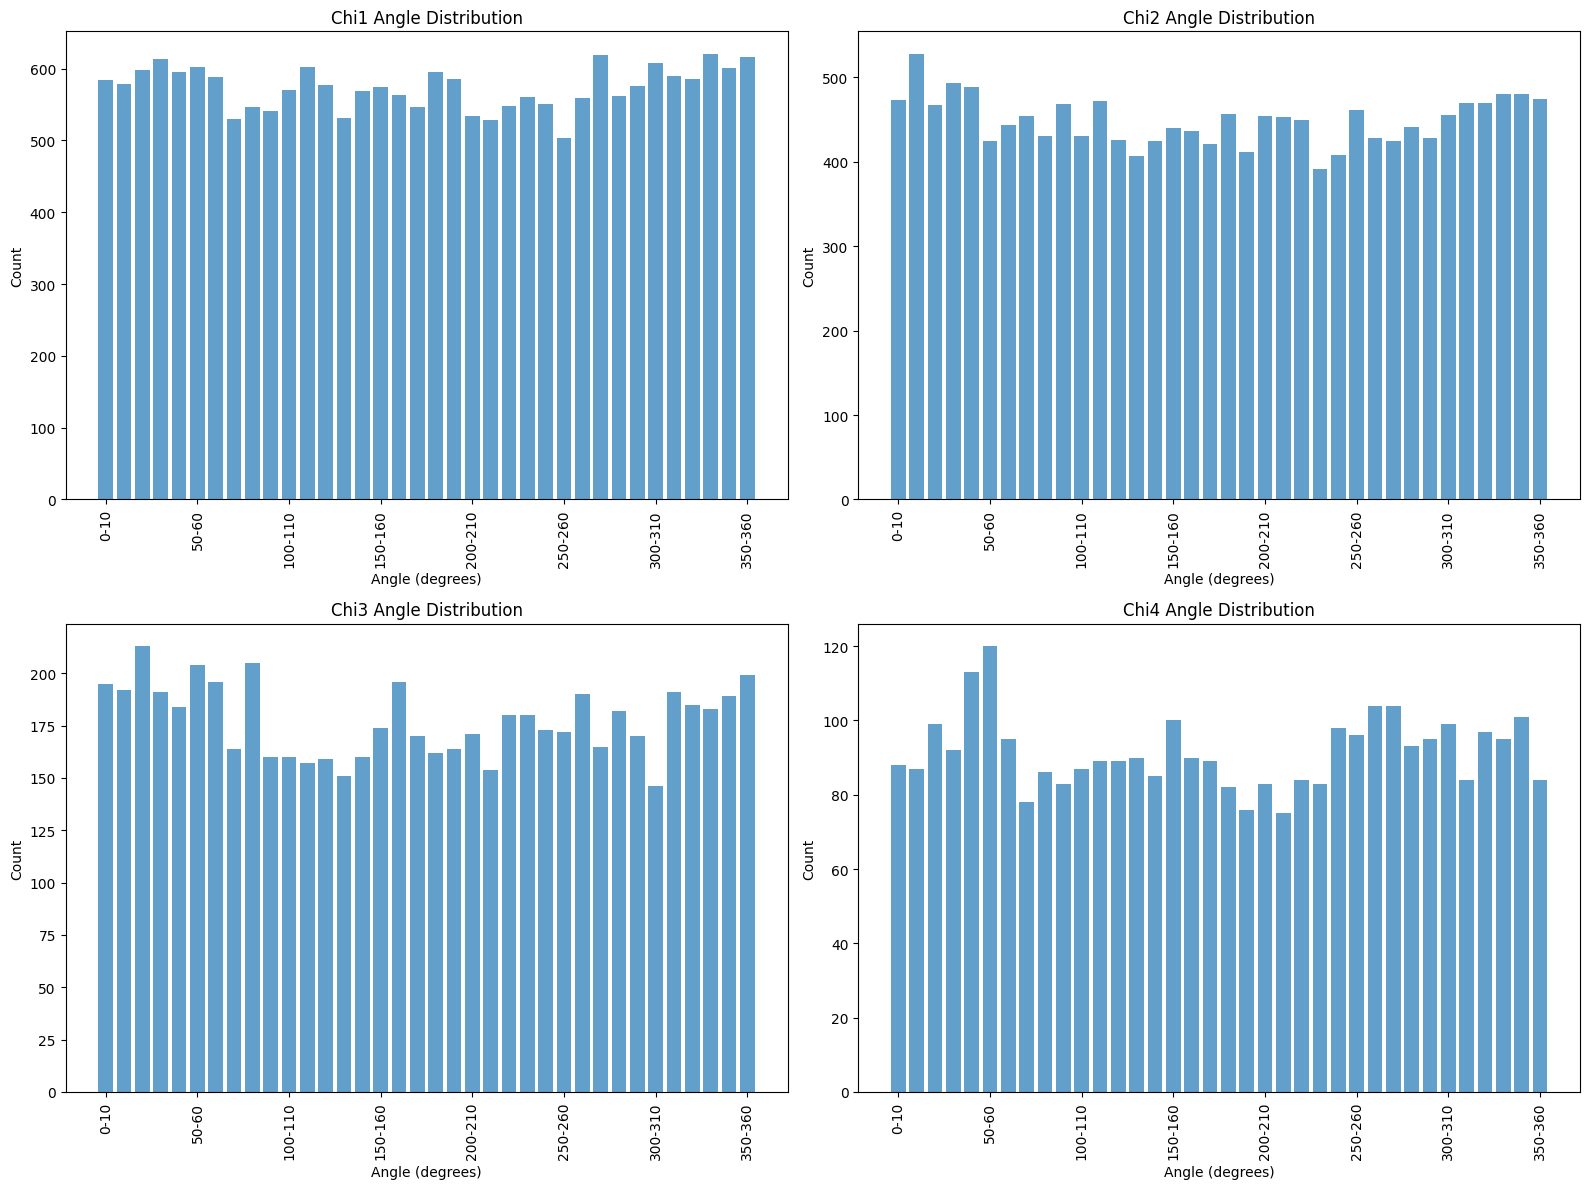

In [36]:
import json
import os 
from tqdm import tqdm
import numpy as np
from Bio import PDB
import pandas as pd
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser

# 初始化计数器，记录chi角分布（chi1、chi2、chi3、chi4）
total_counter = 0
chi_counts = {f'chi{i}': [0] * 36 for i in range(1, 5)}  # 对应36个区间
min_length = 13
def degrees(rad_angle):
    """将弧度角度转换为[0,360]范围内的角度"""
    if rad_angle is None:
        return None
    angle = rad_angle * 180 / np.pi
    while angle > 180:
        angle -= 360
    while angle < -180:
        angle += 360
    return angle + 180

file_path = '/data/private/jdp/PepGLAD/datasets/train_valid/all.txt'
df = pd.read_csv(file_path, sep='\t', header=None, names=['index', 'protein_id', 'peptide_id', 'label'])
df.set_index('index', inplace=True)

# 筛选 label 为 0 的行
df = df[df['label'] == 0]
for idx in tqdm(df.index):
    peptide_path = os.path.join('/data/private/jdp/PepGLAD/datasets/train_valid/pdbs', idx + '.pdb')
    if not os.path.exists(peptide_path):
        print(f"File not found: {peptide_path}")
        continue
    parser = PDBParser(QUIET=True)
    try:
        structure = parser.get_structure('peptide', peptide_path)
    except Exception as e:
        print(f"Error parsing {peptide_path}: {e}")
        continue
    peptide_id = df.loc[idx, 'peptide_id']
    try:
        chain = structure[0][peptide_id]
    except KeyError:
        print(f"Chain {peptide_id} not found in {peptide_path}")
        continue
    
    # 提取多肽链
    ppb = PDB.PPBuilder()
    polypeptides = ppb.build_peptides(chain)

    total_counter += 1
    structure.atom_to_internal_coordinates()  # 初始化内部坐标
    residues = list(chain.get_residues())
    if len(residues) < min_length:
        continue
    # 遍历链中的残基，提取侧链角度
    for residue in chain.get_residues():
        res_name = residue.resname
        
        # 检查是否是标准氨基酸
        if res_name not in PDB.Polypeptide.standard_aa_names:
            continue

        # 提取侧链二面角 chi1 到 chi4
        ic = residue.internal_coord  # 内部坐标
        if ic is None:
            continue  # 如果内部坐标不存在，跳过该残基

        for chi_name in [f'chi{i}' for i in range(1, 5)]:
            try:
                chi_angle = ic.get_angle(chi_name)  # 获取侧链角度
                if chi_angle is not None:
                    chi_deg = degrees(chi_angle)
                    chi_index = int(chi_deg // 10)  # 将角度归为区间
                    chi_counts[chi_name][chi_index] += 1
            except KeyError:
                continue  # 如果指定 chi 角不存在，跳过
            except AttributeError:
                print(f"AttributeError: Residue {res_name} has no internal coordinates")
                continue

file_path = '/data/private/jdp/PepGLAD/datasets/LNR/test.txt'
df = pd.read_csv(file_path, sep='\t', header=None, names=['index', 'protein_id', 'peptide_id', 'label'])
df.set_index('index', inplace=True)

# 筛选 label 为 0 的行
df = df[df['label'] == 0]
for idx in tqdm(df.index):
    peptide_path = os.path.join('/data/private/jdp/PepGLAD/datasets/LNR/pdbs', idx + '.pdb')
    if not os.path.exists(peptide_path):
        print(f"File not found: {peptide_path}")
        continue
    parser = PDBParser(QUIET=True)
    try:
        structure = parser.get_structure('peptide', peptide_path)
    except Exception as e:
        print(f"Error parsing {peptide_path}: {e}")
        continue
    peptide_id = df.loc[idx, 'peptide_id']
    try:
        chain = structure[0][peptide_id]
    except KeyError:
        print(f"Chain {peptide_id} not found in {peptide_path}")
        continue
    
    residues = list(chain.get_residues())
    if len(residues) < min_length:
        continue
    # 提取多肽链
    ppb = PDB.PPBuilder()
    polypeptides = ppb.build_peptides(chain)

    total_counter += 1
    structure.atom_to_internal_coordinates()  # 初始化内部坐标
    
    # 遍历链中的残基，提取侧链角度
    for residue in chain.get_residues():
        res_name = residue.resname
        
        # 检查是否是标准氨基酸
        if res_name not in PDB.Polypeptide.standard_aa_names:
            continue

        # 提取侧链二面角 chi1 到 chi4
        ic = residue.internal_coord  # 内部坐标
        if ic is None:
            continue  # 如果内部坐标不存在，跳过该残基

        for chi_name in [f'chi{i}' for i in range(1, 5)]:
            try:
                chi_angle = ic.get_angle(chi_name)  # 获取侧链角度
                if chi_angle is not None:
                    chi_deg = degrees(chi_angle)
                    chi_index = int(chi_deg // 10)  # 将角度归为区间
                    chi_counts[chi_name][chi_index] += 1
            except KeyError:
                continue  # 如果指定 chi 角不存在，跳过
            except AttributeError:
                print(f"AttributeError: Residue {res_name} has no internal coordinates")
                continue

# 打印结果
print(f"Total samples processed: {total_counter}")
# for chi in chi_counts:
#     print(f"{chi} angle distribution: {chi_counts[chi]}")

# 可视化
bins = [f'{i*10}-{(i+1)*10}' for i in range(0, 36)]

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for i, chi_name in enumerate(chi_counts):
    axs[i].bar(bins, chi_counts[chi_name], alpha=0.7)
    axs[i].set_title(f"{chi_name.capitalize()} Angle Distribution")
    axs[i].set_xlabel("Angle (degrees)")
    axs[i].set_ylabel("Count")
    axs[i].set_xticks(range(0, len(bins), 5))
    axs[i].set_xticklabels(bins[::5], rotation=90)

plt.tight_layout()
plt.show()

no_condition_chi_counts = chi_counts['chi1']+chi_counts['chi2']+chi_counts['chi3']+chi_counts['chi4']

/data/private/jdp/envs/PepGLAD/lib/python3.9/site-packages/Bio/PDB/internal_coords.py:1648: RuntimeWarning: invalid value encountered in divide
  (
/data/private/jdp/envs/PepGLAD/lib/python3.9/site-packages/Bio/PDB/internal_coords.py:1648: RuntimeWarning: invalid value encountered in divide
  (
/data/private/jdp/envs/PepGLAD/lib/python3.9/site-packages/Bio/PDB/internal_coords.py:1648: RuntimeWarning: invalid value encountered in divide
  (
/data/private/jdp/envs/PepGLAD/lib/python3.9/site-packages/Bio/PDB/vectors.py:694: RuntimeWarning: invalid value encountered in arccos
  polar_angle = np.arccos(np.divide(p[:, 2], r, where=r != 0))
/data/private/jdp/envs/PepGLAD/lib/python3.9/site-packages/Bio/PDB/internal_coords.py:1648: RuntimeWarning: invalid value encountered in divide
  (
/data/private/jdp/envs/PepGLAD/lib/python3.9/site-packages/Bio/PDB/internal_coords.py:1648: RuntimeWarning: invalid value encountered in divide
  (
/data/private/jdp/envs/PepGLAD/lib/python3.9/site-packages/Bio

Total samples processed: 130


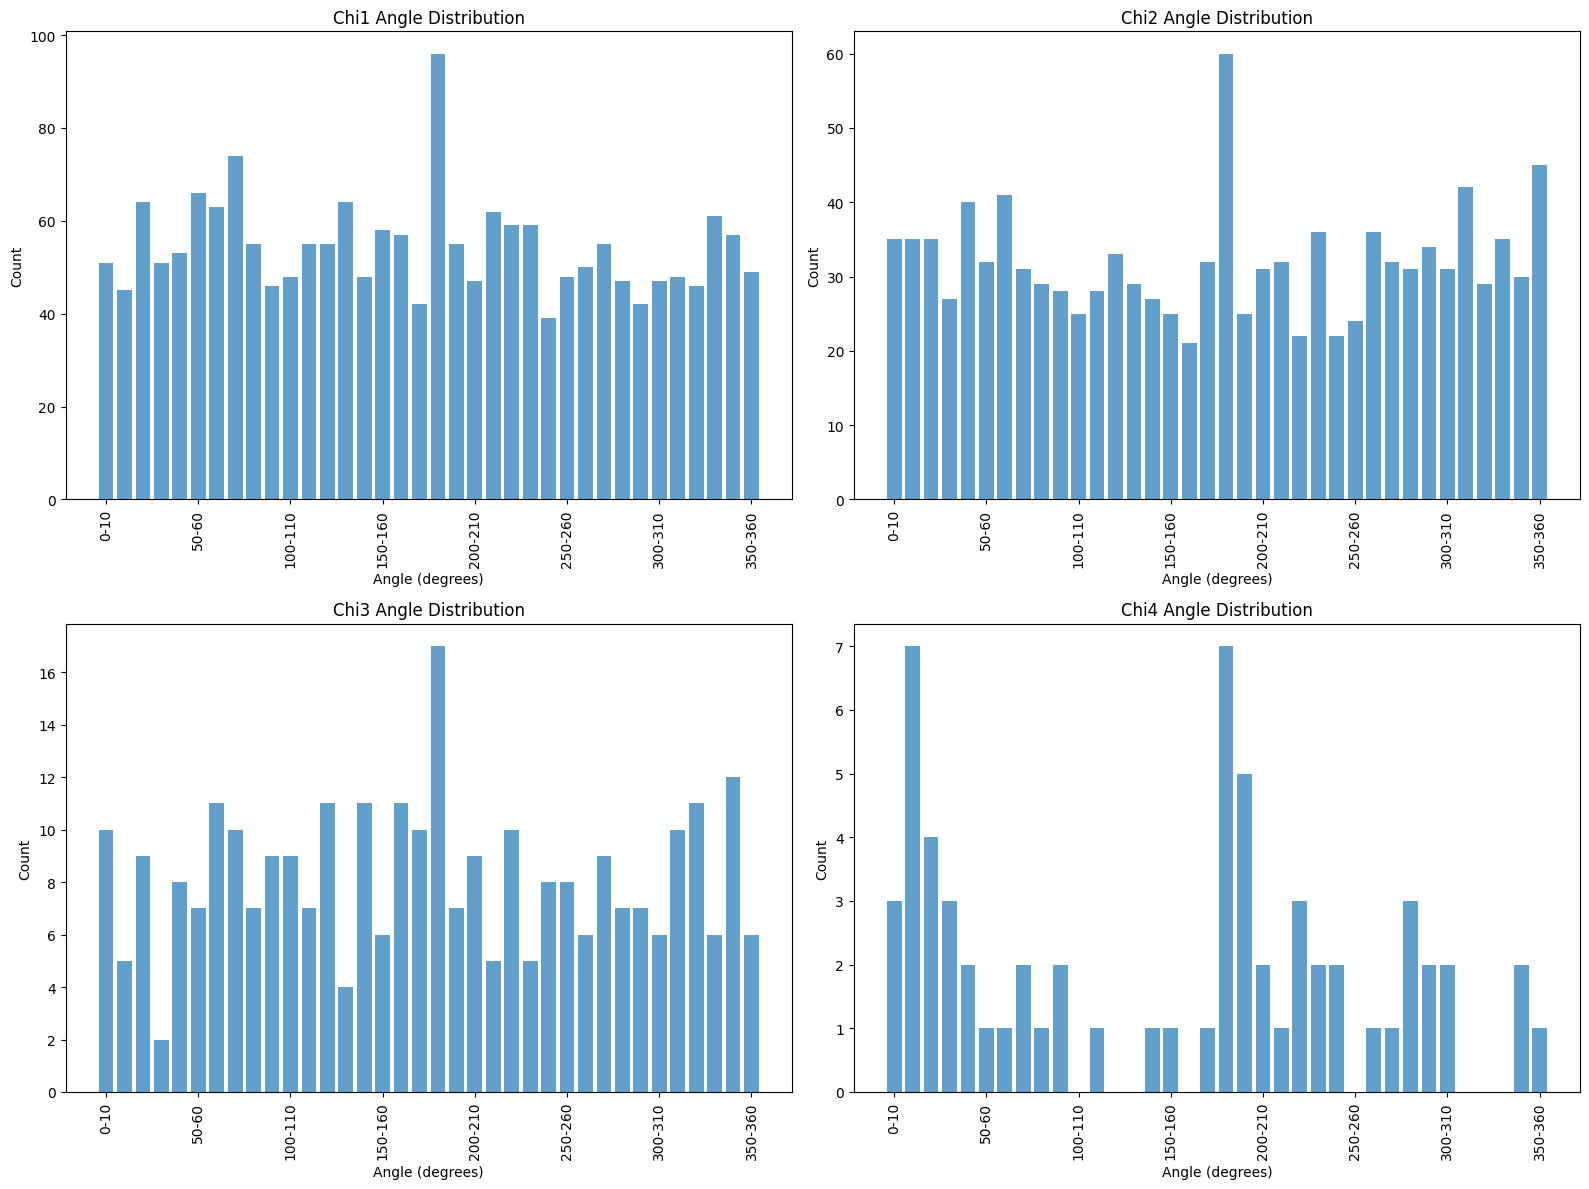

In [49]:
import json
import os 
from tqdm import tqdm
import numpy as np
from Bio import PDB
import pandas as pd
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
min_length = 13
# 文件路径
directory = '/home/jiangdapeng/PepGLAD/results/condition4_w5_5samples/results.jsonl'

# 初始化计数器，记录chi角分布（chi1、chi2、chi3、chi4）
chi_counts = {f'chi{i}': [0] * 36 for i in range(1, 5)}  # 对应36个区间
total_counter = 0  # 统计处理的总蛋白质数量

def degrees(rad_angle):
    """将弧度角度转换为[0,360]范围内的角度"""
    if rad_angle is None:
        return None
    angle = rad_angle * 180 / np.pi
    while angle > 180:
        angle -= 360
    while angle < -180:
        angle += 360
    return angle + 180

# 解析文件
with open(directory, 'r', encoding='utf-8') as f:
    for line in f:
        # 跳过空行
        if line.strip():
            # 将每行解析为 JSON 对象
            json_object = json.loads(line)
            peptide_path = json_object['gen_pdb']
            peptide_path = os.path.join('..',peptide_path)
            peptide = json_object['gen_seq']
            if len(peptide)<min_length:
                continue
            total_counter += 1

            # 读取PDB文件
            parser = PDB.PDBParser(QUIET=True)
            structure = parser.get_structure('peptide', peptide_path)
            structure.atom_to_internal_coordinates()  # 初始化内部坐标
            chain = structure[0][json_object['lig_chain']]  # 假设只取第一个模型和指定的链
            
            # 遍历链中的残基，提取侧链角度
            for residue in chain.get_residues():
                res_name = residue.resname
                
                # 检查是否是标准氨基酸
                if res_name not in PDB.Polypeptide.standard_aa_names:
                    continue

                # 提取侧链二面角 chi1 到 chi4
                ic = residue.internal_coord  # 内部坐标
                if ic is None:
                    continue  # 如果内部坐标不存在，跳过该残基

                for chi_name in [f'chi{i}' for i in range(1, 5)]:
                    try:
                        chi_angle = ic.get_angle(chi_name)  # 获取侧链角度
                        if chi_angle is not None:
                            chi_deg = degrees(chi_angle)
                            if np.isnan(chi_deg):
                                continue
                            chi_index = int(chi_deg // 10)  # 将角度归为区间
                            chi_counts[chi_name][chi_index] += 1
                    except KeyError:
                        continue  # 如果指定 chi 角不存在，跳过
                    except AttributeError:
                        print(f"AttributeError: Residue {res_name} has no internal coordinates")
                        continue

# 打印结果
print(f"Total samples processed: {total_counter}")
# for chi in chi_counts:
#     print(f"{chi} angle distribution: {chi_counts[chi]}")

# 可视化
bins = [f'{i*10}-{(i+1)*10}' for i in range(0, 36)]

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for i, chi_name in enumerate(chi_counts):
    axs[i].bar(bins, chi_counts[chi_name], alpha=0.7)
    axs[i].set_title(f"{chi_name.capitalize()} Angle Distribution")
    axs[i].set_xlabel("Angle (degrees)")
    axs[i].set_ylabel("Count")
    axs[i].set_xticks(range(0, len(bins), 5))
    axs[i].set_xticklabels(bins[::5], rotation=90)

plt.tight_layout()
plt.show()

with_condition_chi_counts = chi_counts['chi1']+chi_counts['chi2']+chi_counts['chi3']+chi_counts['chi4']

In [50]:
import numpy as np

def kl_divergence(P, Q):
    # 归一化
    P = np.array(P) / np.sum(P)
    Q = np.array(Q) / np.sum(Q)
    
    # 确保Q中没有零值
    epsilon = 1e-10
    P = P + epsilon
    Q = Q + epsilon
    
    # 计算KL散度
    return np.sum(P * np.log(P / Q))

kl_div = kl_divergence(no_condition_chi_counts, with_condition_chi_counts)
print(f"KL Divergence: {kl_div}")

KL Divergence: 0.3351181104301689
